In [32]:
#simple direct problem solving 

import matplotlib.pyplot as plt

# from clspde.solution import Solution
from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

a = 1
b = 1

eps = 0.01

beta = 0.2
gamma = 0.15


power = 4
params = {
    'n_dims': 2,
    'dim_sizes': np.array([6, 6]),
    'area_lims': np.array([[0,0.1], [0,1]]),
    'power': power,
    'basis': Basis(power),
    'n_funcs': 6,
}
sol = Solution(**params)
# w = np.sqrt(2) #(sol.steps[0]/2)
# w = 1/sol.steps[0]
# k1 = 50
# k2 = 5
# border_weight = sol.steps[0]**(-1) * 100
# no_need_weight = 0
# border_weight = 100

# w = (sol.steps[0]/2)
# w = 1/sol.steps[0]
w = 1
k1 = 10#50
k2 = 0.5#1#5
border_weight = 1 # sol.steps[0]**(-1) * 100
no_need_weight = 0


def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

# c_p_1d = f_collocation_points(int(np.ceil(power/2))).reshape(int(np.ceil(power/2))+1)
# power = int(3/2*power)
c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))


connect_points = np.array([[-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],])
                            
border_points = connect_points

colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0) #s
                                                                                            + beta * (u_bas([0,0],0)*u_loc([0,0],1)
                                                                                                    + u_loc([0,0],0)*u_bas([0,0],1))
                                                                                            -(u_bas([0,1],0)*u_loc([0,1],3)+
                                                                                              u_loc([0,1],0)*u_bas([0,1],3)+

                                                                                             u_loc([0,0],0)*u_bas([0,2],3)+
                                                                                             u_bas([0,0],0)*u_loc([0,2],3))
                                                                                          ) * w**2,
                        lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],1)-eps*u_bas([0,2],1) #i
                                                                                            - beta * (u_bas([0,0],0)*u_loc([0,0],1)
                                                                                                     +u_loc([0,0],0)*u_bas([0,0],1))
                                                                                            + gamma * u_bas([0,0],1)
                                                                                            -(u_bas([0,1],1)*u_loc([0,1],4)+
                                                                                              u_loc([0,1],1)*u_bas([0,1],4)+

                                                                                             u_loc([0,0],1)*u_bas([0,2],4)+
                                                                                             u_bas([0,0],1)*u_loc([0,2],4))
                                                                                          ) * w**2,
                        lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],2)-eps*u_bas([0,2],2) #r
                                                                                            - gamma * u_bas([0,0],1)
                                                                                            -(u_bas([0,1],2)*u_loc([0,1],5)+
                                                                                              u_loc([0,1],2)*u_bas([0,1],5)+

                                                                                             u_loc([0,0],2)*u_bas([0,2],5)+
                                                                                             u_bas([0,0],2)*u_loc([0,2],5))
                                                                                          ) * w**2,



                        lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],3)-eps*u_bas([0,2],3)
                                                                                            + beta * (u_loc([0,0],1) * (u_bas([0,0],3) - u_bas([0,0],4))
                                                                                                        + u_bas([0,0],1) * (u_loc([0,0],3) - u_loc([0,0],4)))
                                                                                             +2*(u_bas([0,1],3)*u_loc([0,1],3))
                                                                                            ) * w**2 ,
                        lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],4)-eps*u_bas([0,2],4)
                                                                                            - beta * (u_loc([0,0],0) * (u_bas([0,0],3) - u_bas([0,0],4))
                                                                                                        + u_bas([0,0],0) * (u_loc([0,0],3) - u_loc([0,0],4)))
                                                                                            + gamma * (u_bas([0,0],4) - u_bas([0,0],5)) 
                                                                                            +2*(u_bas([0,1],4)*u_loc([0,1],4))
                                                                                            ) * w**2 ,
                        lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],5)-eps*u_bas([0,2],5)
                                                                                            +2*(u_bas([0,1],5)*u_loc([0,1],5))
                                                                                            ) * w**2 ,

                                                                                            ]

                                            

def popravka(f,g):
    return f*g
colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: (-popravka(u_loc([0,1],0), u_loc([0,1],3)) - popravka(u_loc([0,0],0), u_loc([0,2],3))
                                                         +beta*popravka(u_loc([0,0],0), u_loc([0,0],1))) * w**2,  #2*u_loc([0,0],0)*u_loc([0,1],1)**2 * w**2, #0, 
                            lambda u_loc, u_nei, x, x_loc: (-popravka(u_loc([0,1],1), u_loc([0,1],4)) - popravka(u_loc([0,0],1), u_loc([0,2],4))
                                                         -beta*popravka(u_loc([0,0],0), u_loc([0,0],1))) * w**2,  #2*u_loc([0,0],0)*u_loc([0,1],1)**2 * w**2, #0, 
                            lambda u_loc, u_nei, x, x_loc: (-popravka(u_loc([0,1],2), u_loc([0,1],5)) - popravka(u_loc([0,0],2), u_loc([0,2],5))) * w**2,  #2*u_loc([0,0],0)*u_loc([0,1],1)**2 * w**2, #0, 

                          lambda u_loc, u_nei, x, x_loc: (beta*popravka(u_loc([0,0],1),  (u_loc([0,0],3) - u_loc([0,0],4)))
                                                          +popravka(u_loc([0,1],3),  u_loc([0,1],3))) * w**2,
                          lambda u_loc, u_nei, x, x_loc: (-beta * popravka(u_loc([0,0],0),  (u_loc([0,0],3) - u_loc([0,0],4)))
                                                          +popravka(u_loc([0,1],4),  u_loc([0,1],4))) * w**2,
                          lambda u_loc, u_nei, x, x_loc: popravka(u_loc([0,1],5),  u_loc([0,1],5)) * w**2,
                          
                          ]
colloc_ops = [colloc_left_operators, colloc_right_operators]


def initial_state(x):
    t, x = x
    sm_x = 3*x-1
    if (x<2/3 and x>1/3):
        return np.array([0.97, 0.02, 0.01]) * 3 * 12 * (sm_x**2) *(1-sm_x)
    else:
        return np.array([0,0,0])

def terminal_state(x):
    sm_x = 3*x-1
    if (x<2/3 and x>1/3):
        return np.array([1, 0., 0.])* 12*sm_x*(1-sm_x)**2 *3
    else:
        return [0,0,0]

small = 1e-5

# border_left_operators = [lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*int(x[0]<sol.area_lims[0,1]-small)*(u_bas([0,0],1)) * border_weight,
                         
#                         lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],1)-u_bas([0,0],0)) * border_weight,
                         
#                         lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*u_bas([0,0],0) * border_weight,
#                             ]

border_left_operators = [
    #s_PSI border conditions
    lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*int(x[0]<sol.area_lims[0,1]-small)*(u_bas([0,0],3)) * border_weight,
    #i_PSI border conditions
    lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*int(x[0]<sol.area_lims[0,1]-small)*(u_bas([0,0],4)) * border_weight,
    #r_PSI border conditions
    lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*int(x[0]<sol.area_lims[0,1]-small)*(u_bas([0,0],5)) * border_weight,
                         
    # lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],3)-u_bas([0,0],0)) * border_weight, #* no_need_weight,
    lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],3)) * border_weight, #* no_need_weight,
    lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],4)-u_bas([0,0],1)) * border_weight,
    # lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],5)-u_bas([0,0],2)) * border_weight, #* no_need_weight,
    lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],5)) * border_weight, #* no_need_weight,
            
    lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*u_bas([0,0],0) * border_weight,
    lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*u_bas([0,0],1) * border_weight,
    lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*u_bas([0,0],2) * border_weight,
    ]

border_right_operators = [
    lambda u, _, x, x_loc: 0 * border_weight, # border condition for psi-s
    lambda u, _, x, x_loc: 0 * border_weight, # border condition for psi-s
    lambda u, _, x, x_loc: 0 * border_weight, # border condition for psi-s
                            
    # terminal conditions for psis
    lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (-terminal_state(x[1])[0]) * border_weight,# * no_need_weight,
    lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (-terminal_state(x[1])[1]) * border_weight,
    lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (-terminal_state(x[1])[2]) * border_weight,# * no_need_weight,
                            
    lambda u, _, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*initial_state(x)[0] * border_weight, # border and initial cond for s
    lambda u, _, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*initial_state(x)[1] * border_weight, # border and initial cond for i
    lambda u, _, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*initial_state(x)[2] * border_weight, # border and initial cond for r
]

border_ops = [border_left_operators, border_right_operators]

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
connect_points = np.array([
                            # [-1, 0.5], [1, 0.5],
                            # [0.5, -1], [0.5, 1],
                            # [-1, -0.5], [1, -0.5],
                            # [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            ])
border_points = connect_points
points=[colloc_points, connect_points ,border_points]

connect_left_operators = []
connect_right_operators = []

def dir(point: np.array) -> np.array:
    direction = (np.abs(point) == 1) * (np.sign(point))
    return np.array(direction, dtype=int)
for func_num in range(sol.n_funcs):
    # connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc),func_num) + np.sum(dir(x_loc))*int(abs(x_loc[1])==1)*u_bas([0,1],func_num)]
    # connect_right_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc),func_num) -  np.sum(dir(x_loc))*int(abs(x_loc[1])==1)*u_bas([0,1],func_num)]
    connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc),func_num) + k2*np.sum(dir(x_loc))*u_bas([0,1],func_num) * np.prod(dir(np.array([0.5,1]))==[0,1])]
    connect_right_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc),func_num) -  k2*np.sum(dir(x_loc))*u_bas([0,1],func_num) * np.prod(dir(np.array([0.5,1]))==[0,1])]
connect_ops = [connect_left_operators, connect_right_operators]

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
       'connect_ops':connect_ops
}

sol.cells_coefs *= 0.0


0

In [4]:
A, b = sol.global_solve(**iteration_dict, solver = 'np', return_system=True, calculate=False)

In [31]:
A, b = sol.global_solve(**iteration_dict, solver = 'np', return_system=True)

Переформулировать условие на S компоненту, чтобы она отображала экономическую составляющую модели.

In [35]:
for i in range(5):
    print(i)
    A, b = sol.global_solve(**iteration_dict, solver = 'np', return_system=True)

0
1
2
3
4


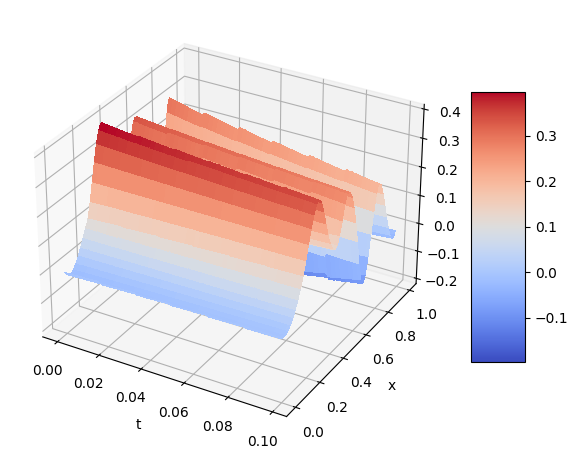

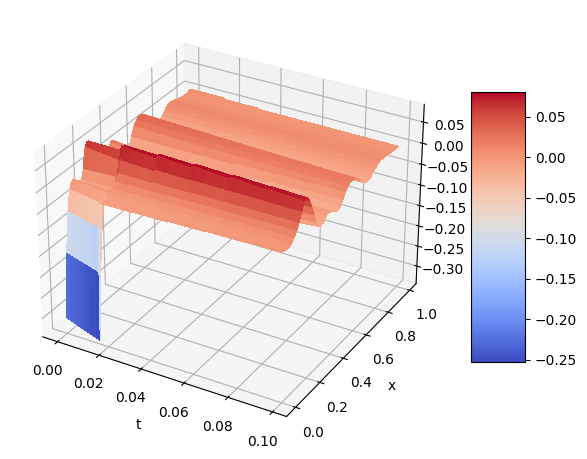

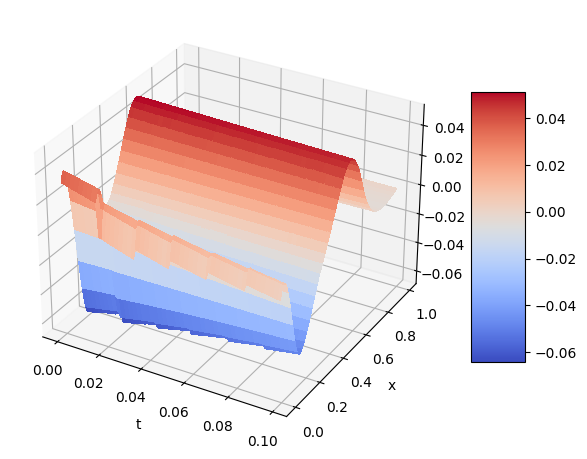

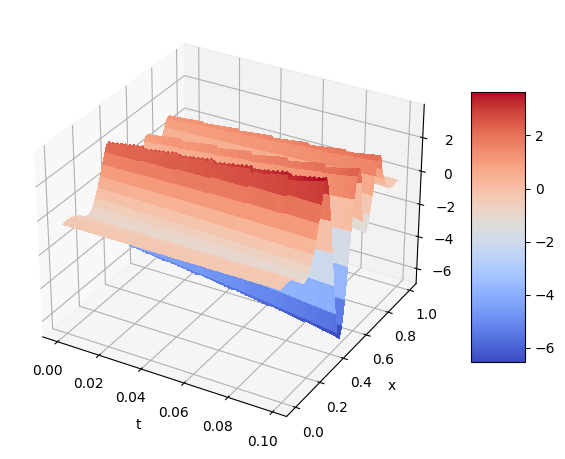

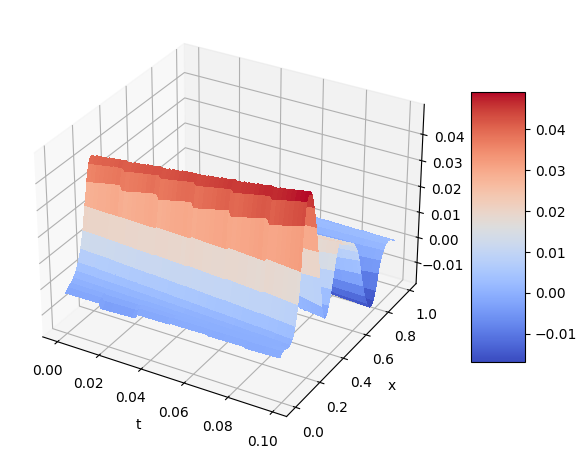

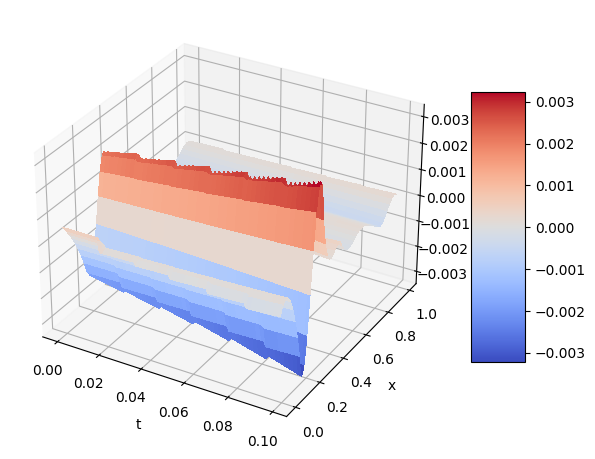

In [34]:
for i in range(6):
    sol.plot2d(func_num=i)